# Sampling Methods

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/b/bf/Simple_random_sampling.PNG" width="400px" height="400px" />

> We now have a suite of methods for **exact** inference. Although these methods exploit the graphical structure of our networks, they are not efficient (in the general case) in the sense that the time they need to obtain the result is exponential in the size of the problem.
>
> Therefore, we will study sampling methods to achieve approximate inference in graphical models.

> **Objetives:**
> - To remember how to estimate statistics using samples.
> - To study a simple sampling method for Bayesian networks.
> - To describe the Markov Chain Monte Carlo methods.

> **References:**
> - Probabilistic Graphical Models: Principles and Techniques, By Daphne Koller and Nir Friedman. Ch. 12.
> - Mastering Probabilistic Graphical Models Using Python, By Ankur Ankan and Abinash Panda. Ch. 4.
> - Probabilistic Graphical Models Specialization, offered through Coursera. Prof. Daphne Koller.


<p style="text-align:right;"> Imagen recuperada de: https://upload.wikimedia.org/wikipedia/commons/b/bf/Simple_random_sampling.PNG.</p>

___

# 1. Sampling in Bayesian Networks

First, let's remember how we estimate simple things using samples from a distribution $P$.

## 1.1. Simple sampling

Let $\mathcal{D}=\{x_1, x_2, \dots, x_M\}$ be a dataset of **independent and identically distributed (IID)** samples from the distribution $P(X=x)$.

For example, if $X$ is a binary random variable ($\mathrm{Val}(X)=\{x^0, x^1\}$) and $P(X=x^1)=p$, then an estimator for $p$ is:

$$\hat{p} = \frac{1}{M} \sum_{i=1}^{M} I(x_i = x^1).$$

In [1]:
# Import numpy
import numpy as np

In [2]:
help(np.random.choice)

Help on built-in function choice:

choice(...) method of numpy.random.mtrand.RandomState instance
    choice(a, size=None, replace=True, p=None)
    
    Generates a random sample from a given 1-D array
    
            .. versionadded:: 1.7.0
    
    .. note::
        New code should use the ``choice`` method of a ``default_rng()``
        instance instead; see `random-quick-start`.
    
    Parameters
    ----------
    a : 1-D array-like or int
        If an ndarray, a random sample is generated from its elements.
        If an int, the random sample is generated as if a were np.arange(a)
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    replace : boolean, optional
        Whether the sample is with or without replacement
    p : 1-D array-like, optional
        The probabilities associated with each entry i

In [6]:
# Sample the binary distribution
data = np.random.choice(a=[0, 1], p=[0.3, 0.7], size=100000)

In [7]:
data

array([1, 1, 1, ..., 0, 1, 1])

In [8]:
# Estimation of p
p_hat = (data == 1).mean()
p_hat

0.70035

More generally, for any distribution $P$ and function $f$,

$$E_P[f] \approx \frac{1}{M} \sum_{i=1}^{M}f(x_i).$$

**Application of this simple concept:**

- [Montecarlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration)

### How can we sample from a multinomial discrete distribution?

Let $X$ be a discrete random variable with $\mathrm{Val}(X)=\{x^1, x^2, \dots, x^k\}$, and $P(x^i) = \theta^i$.

Usually we have a pseudorandom number generator from the uniform distribution $\mathcal{U}[0, 1]$ (equal probability of drawing any number between 0 and 1):

In [10]:
# numpy.random.rand
help(np.random.rand)

Help on built-in function rand:

rand(...) method of numpy.random.mtrand.RandomState instance
    rand(d0, d1, ..., dn)
    
    Random values in a given shape.
    
    .. note::
        This is a convenience function for users porting code from Matlab,
        and wraps `random_sample`. That function takes a
        tuple to specify the size of the output, which is consistent with
        other NumPy functions like `numpy.zeros` and `numpy.ones`.
    
    Create an array of the given shape and populate it with
    random samples from a uniform distribution
    over ``[0, 1)``.
    
    Parameters
    ----------
    d0, d1, ..., dn : int, optional
        The dimensions of the returned array, must be non-negative.
        If no argument is given a single Python float is returned.
    
    Returns
    -------
    out : ndarray, shape ``(d0, d1, ..., dn)``
        Random values.
    
    See Also
    --------
    random
    
    Examples
    --------
    >>> np.random.rand(3,2)
    arra

Thus, we can sample as shown in the following image:

In [11]:
from IPython.display import Image

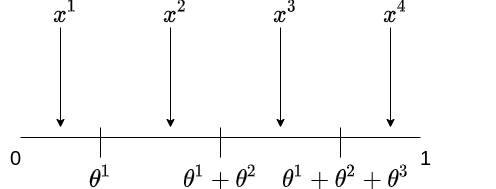

In [12]:
Image(filename='figures/discrete_sampling.png')

### What theoretical guarantees do we have?

> *Theorem (Hoeffding bound).* For the estimator $\hat{p} = \frac{1}{M} \sum_{i=1}^{M} I(x_i = x^1)$, the inequality
> 
> $$P_{\mathcal{D}}(\hat{p}\notin[p-\epsilon, p+\epsilon]) \leq 2 e^{-2 M \epsilon^2}$$
>
> holds.

> *Theorem (Chernoff bound).* For the estimator $\hat{p} = \frac{1}{M} \sum_{i=1}^{M} I(x_i = x^1)$, the inequality
> 
> $$P_{\mathcal{D}}(\hat{p}\notin[p(1-\epsilon), p(1+\epsilon)]) \leq 2 e^{- M p \epsilon^2 / 3}$$
>
> holds.

**Comments:**

1. Hoeffding: additive error
2. Chernoff: multiplicative errror
3. Both say that "the probability of a bad sample set (with error $\epsilon$)" is a decreasing function of the number of samples.
4. These guarantees are extended for estimation over general functions.
5. Issues appear when $p$ (the true value is small): $\epsilon$ needs to be small relative to $p$.

**Exercise.**

Assume that we want to be at least $1-\delta$ confident that we will have a good estimator. How many samples do we need?

## 1.2. Forward sampling in Bayesian networks

There are several ways to perform sampling over a Bayesian network. The *forward sampling* is perhaps the easiest and practical way to do it, since it is done in the natural calusal direction of the model.

Let's consider the student example:

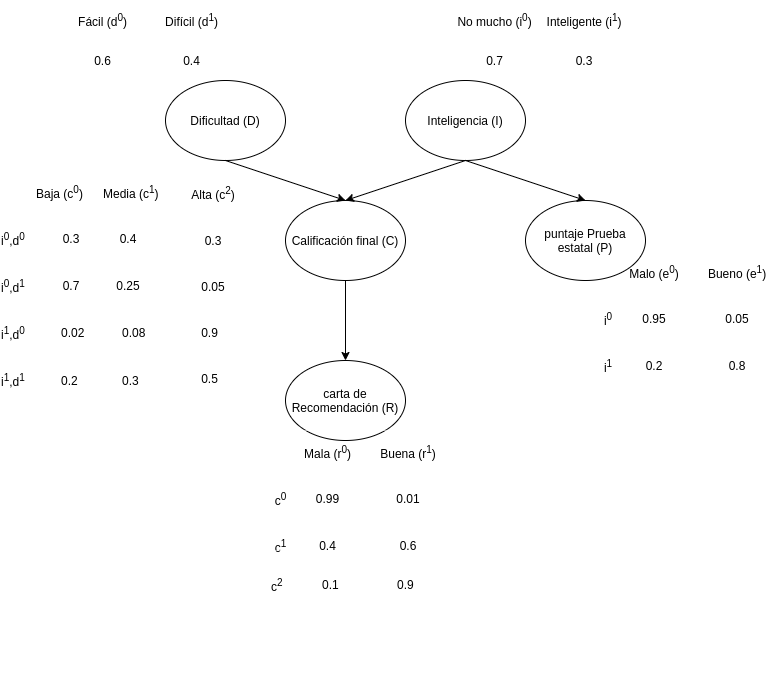

In [13]:
Image(filename='figures/Student1.png')

The sampling is done in the topological order:

1. We begin with the nodes that don't have parents ($D,I$):
   - $d^0, i^1$.

2. Once the parents of a node have been sampled, we can sample that node using the corresponding row of the conditional distribution ($C,E$ using the rows corresponding to $i^1, d^0$):
   - $c^0, e^0$.
   - $r^1$

3. Finally, the complete sample is $d^0, i^1, c^0, e^0, r^1$.

### How do we estimate probabilities using these samples?

1. Goal: To estimate $P(\bar{Y}=\bar{y})$ (or a function of $\bar{Y}$).

   - Generate and collect samples from the Bayesian network. How many? 
   - Count the number of times that $\bar{Y}=\bar{y}$ and compute its relative frequency.

### What if we have evidence?

2. Goal: To estimate $P(\bar{Y}=\bar{y} | \bar{E}=\bar{e})$.

   - Rejection sampling algorithm:
     - Generate samples from the Bayesian network.
     - Throw away all those where $\bar{E} \neq \bar{e}$
     - Count the number of times that $\bar{Y}=\bar{y}$ and compute its relative frequency.
     
   - Expected fraction of samples kept after throwing away those that are not consistent with the evidence: $P(\bar{e})$.
   - Thus, we should generate: $M\geq \frac{\log(2/\delta)}{2P(\bar{e})\epsilon^2}$ samples

> The number of samples grows exponentially with the number of observed variables.

### How is this done with `pgmpy`?

First, let's compute the exact inference:

In [14]:
# Import pgmpy.factors.discrete.TabularCPD
from pgmpy.factors.discrete import TabularCPD
# Import pgmpy.models.BayesianModel
from pgmpy.models import BayesianModel

In [15]:
# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianModel([('D', 'C'), ('I', 'C'), ('C', 'R'), ('I', 'E')])

In [16]:
# Defining individual CPDs
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]])
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]])
cpd_c = TabularCPD(variable='C', variable_card=3, 
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2])

cpd_r = TabularCPD(variable='R', variable_card=2, 
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['C'],
                   evidence_card=[3])

cpd_e = TabularCPD(variable='E', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2])

In [17]:
# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_c, cpd_r, cpd_e)

In [18]:
model.check_model()

True

Compute the marginal probability $P(C)$

In [19]:
# Import pgmpy.inference.VariableElimination
from pgmpy.inference import VariableElimination

In [20]:
ve_inference = VariableElimination(model)

In [21]:
P_C = ve_inference.query(variables=['C'])
print(P_C)

Eliminating: R: 100%|██████████| 4/4 [00:00<00:00, 401.81it/s]

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.3620 |
+------+----------+
| C(1) |   0.2884 |
+------+----------+
| C(2) |   0.3496 |
+------+----------+


Now, let's see what we get using forward sampling:

In [22]:
# Import pgmpy.sampling.BayesianModelSampling
from pgmpy.sampling import BayesianModelSampling

In [23]:
# Instantiate a sampling object
sampling = BayesianModelSampling(model)

In [28]:
# Number of samples for error of 1% and confidence of 99%
eps = 0.01
delta = 0.01
M = np.ceil(np.log(2/delta) / (2 * eps**2)).astype(int)
M

26492

In [37]:
# Generate samples
samples = sampling.forward_sample(size=M)
samples.head()

Generating for node: R: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


,I,E,D,C,R
0,0,0,0,2,0
1,0,0,0,2,0
2,1,1,0,0,1
3,1,1,1,0,1
4,0,0,1,2,0


In [38]:
# Estimation of P(C)
P_C_hat = samples['C'].value_counts() / M
P_C_hat[[0, 1, 2]]

0    0.357617
1    0.291560
2    0.350823
Name: C, dtype: float64

In [41]:
P_C_hat

0    0.357617
2    0.350823
1    0.291560
Name: C, dtype: float64

In [39]:
# Compare
print(P_C)

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.3620 |
+------+----------+
| C(1) |   0.2884 |
+------+----------+
| C(2) |   0.3496 |
+------+----------+


In [42]:
P_C.values - P_C_hat[[0, 1, 2]].values

array([ 0.00438261, -0.00315972, -0.00122289])

Unfortunately, this method cannot be extended to Markov networks.

# 2. Markov Chain Monte Carlo

The Markov Chain Monte Carlo (MCMC) methods appear as an answer to the above issue. These methods allow us to design an iterative sampling process that converges to the desired target distribution, which may be intractable to sample from directly.

Let's remember what the Markov chains are:

## 2.1. Markov chains

Recall that a **Markov chain** defines a probabilistic transition model $T(x \to x')$ over some states $x$:

$$\forall x: \sum_{x'}T(x \to x') = 1.$$

**Example:** Drunk man Markov chain

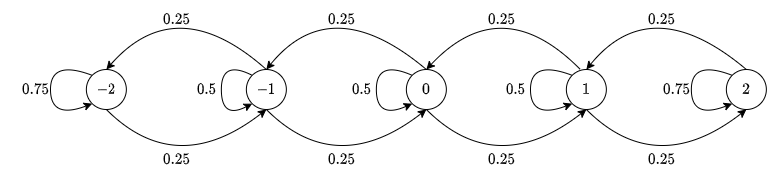

In [43]:
Image("figures/drunkMC.png")

### How does the probability of being in a given state evolve?

Given some initial probability distribution $P^{(0)}(X^{(0)})$, we can find $P^{(t)}(X^{(t)})$ as:

$$P^{(t+1)}(X^{(t+1)} = x') = \sum_{x} P^{(t)}(X^{(t)}) T(x \to x').$$

For example, we know that the drunk man begins his journey at $X=0$. Then:

| $P^{(t)}$ | $-2$     | $-1$   | $0$     | $1$   | $2$      |
| --------- | -------- | ------ | ------- | ----- | -------- |
| $P^{(0)}$ | $0$      | $0$    | $1$     | $0$   | $0$      |
| $P^{(1)}$ | $0$      | $0.25$ | $0.5$   | $0.25$| $0$      |
| $P^{(2)}$ | $0.0625$ | $0.25$ | $0.375$ | $0.25$| $0.0625$ |

In [44]:
# Import numpy
import numpy as np

In [45]:
# Transition matrix
T = np.array([[0.75, 0.25, 0.00, 0.00, 0.00],
              [0.25, 0.50, 0.25, 0.00, 0.00],
              [0.00, 0.25, 0.50, 0.25, 0.00],
              [0.00, 0.00, 0.25, 0.50, 0.25],
              [0.00, 0.00, 0.00, 0.25, 0.75]])
# Initial distribution
P0 = np.array([0, 0, 1, 0, 0])

In [46]:
# Distribution 1, 2, ..., 10
P1 = T.dot(P0)
P1

array([0.  , 0.25, 0.5 , 0.25, 0.  ])

In [48]:
P2 = T.dot(P1)
P2 = np.linalg.matrix_power(T, 2).dot(P0)
P2

array([0.0625, 0.25  , 0.375 , 0.25  , 0.0625])

In [49]:
P10 = np.linalg.matrix_power(T, 10).dot(P0)
P10

array([0.19533157, 0.20178318, 0.20577049, 0.20178318, 0.19533157])

In [50]:
# Distribution 100
P100 = np.linalg.matrix_power(T, 100).dot(P0)
P100

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [51]:
# Distribution 1000
P1000 = np.linalg.matrix_power(T, 1000).dot(P0)
P1000

array([0.2, 0.2, 0.2, 0.2, 0.2])

After some iterations, the distribution converges to an stationary distribution.

What happens if the initial distribution is changed?

In [52]:
# Try different P0
P0 = np.array([0, 0.5, 0.5, 0, 0])
P1000 = np.linalg.matrix_power(T, 1000).dot(P0)
P1000

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [54]:
# Try different P0
P0 = np.array([1, 0, 0, 0, 0])
P1000 = np.linalg.matrix_power(T, 1000).dot(P0)
P1000

array([0.2, 0.2, 0.2, 0.2, 0.2])

Then, the stationary distribution satisfies:

$$\Pi(x') = \sum_{x} \Pi(x) T(x \to x'),$$

and

$$\sum_{x} \Pi(x) = 1,$$

which forms a system of linear equations.

For the above example:

In [59]:
# Modify and augment matrix
mat = np.concatenate((np.eye(5) - T, np.ones((1, 5))))
b = np.concatenate((np.zeros((5, 1)), np.ones((1, 1))))

In [60]:
mat, b

(array([[ 0.25, -0.25,  0.  ,  0.  ,  0.  ],
        [-0.25,  0.5 , -0.25,  0.  ,  0.  ],
        [ 0.  , -0.25,  0.5 , -0.25,  0.  ],
        [ 0.  ,  0.  , -0.25,  0.5 , -0.25],
        [ 0.  ,  0.  ,  0.  , -0.25,  0.25],
        [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ]]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]]))

In [61]:
help(np.linalg)

Help on package numpy.linalg in numpy:

NAME
    numpy.linalg

DESCRIPTION
    ``numpy.linalg``
    
    The NumPy linear algebra functions rely on BLAS and LAPACK to provide efficient
    low level implementations of standard linear algebra algorithms. Those
    libraries may be provided by NumPy itself using C versions of a subset of their
    reference implementations but, when possible, highly optimized libraries that
    take advantage of specialized processor functionality are preferred. Examples
    of such libraries are OpenBLAS, MKL (TM), and ATLAS. Because those libraries
    are multithreaded and processor dependent, environmental variables and external
    packages such as threadpoolctl may be needed to control the number of threads
    or specify the processor architecture.
    
    - OpenBLAS: https://www.openblas.net/
    - threadpoolctl: https://github.com/joblib/threadpoolctl
    
    Please note that the most-used linear algebra functions in NumPy are present in
    t

In [66]:
# Least squares solution
Pi, _, _,_ = np.linalg.lstsq(mat, b)
Pi

/home/esteban/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2]])

However, **not all Markov chains converge to a unique distribution regardless the initial probability distribution**.

> *Definition (Regular Markov chain).* A Markov chain is **regular** if there exists $k\in\mathbb{N}$ such that, for every $x, x' \in \mathrm{Val}(X)$, the probability of getting from $x$ to $x'$ in exactly $k$ steps is *positive* ($>0$).

> *Theorem.* A regular Markov chain converges to a unique stationary distribution regardless the initial distribution.

**Sufficient condition for regularity:**
- Every two states $x, x'$ are connected with a path of positive probability.
- For every state, there is a self-transition.

## 2.2. Using a Markov chain

Now that we know what a Markov chain is, let's examine how to use it in the context of approximate inference using sampling.

- Goal: Compute $P(x \in \mathcal{S})$.
  - But $P$ is too hard to sample from directly.
  
- Construct a Markov chain whose unique stationary distribution is $P$.

- Sample $x^{(0)}$ from $P^{(0)}$.

- For $t=0, 1, 2, \dots$:
  - Generate $x^{(t+1)}$ from $T(x^{(t)} \to x')$.

### Which samples will we use?

We only want to use samples that are sampled form a distribution which is close to $P$.

However, at early iterations, $P^{(t)}$ is usually far from $P$.

We should start collecting samples only after the chain has run long enough to **mix**.

### How do you know if a chain has mixed or not?

In general, it is very difficult to prove that a chain has mixed.

In many cases, you can prove that it has not:

 - Compare chain statistics in different windows within a single run of the chain;
 - and accross different runs initialized differently.

### Using the samples

Once the chain mixes, all samples $x^{(t)}$ are from the stationary distribution $\Pi$:

 - So we should use all $x^{(t)}$ for $t>T_{mix}$.

Nearby samples are correlated (not IID)!
 - We shouldn't overestimate the quality of our estimator by simple counting the number of samples.

### Algorithm

1. For $c=1,\dots,C$:
   - Sample $x^{(c,0)}$ from $P^{(0)}$.
   
2. Repeat until mixing:
   - For $c=1,\dots,C$:
     - Generate $x^{(c,t+1)}$ from $T(x^{(c,t)} \to x')$.
     - Compare window statistics in different chains to determine mixing.

3. Repeat until sufficient samples:
   - $\mathcal{D} = \emptyset$.
   - For $c=1,\dots,C$:
     - Generate $x^{(c,t+1)}$ from $T(x^{(c,t)} \to x')$.
     - $\mathcal{D} = \mathcal{D} \cup \{x^{(c,t+1)}\}$.

**Pros:**
- General purpose.
- Easy to implement.
- Good theoretical guarantees as $t\to\infty$.

**Cons:**
- Lots of design choices.
- Can be very slow to converge.
- Difficult to tell whether it is working.

## 2.3. Gibbs sampling

Until now we have the general framework clear. However, we still do not know how to construct a Markov chain with a desired unique stationary distribution.

One simple way to do this is using the Gibbs chain.

- Target distribution $P_{\Phi}(X_1, \dots, X_n)$.
- Markov chain state space: complete assinment $\bar{x}$ to $\bar{X} = \{X_1, \dots, X_n\}$.
- Transition model given an starting state $\bar{x}^{(0)}$:
  - For $i=1,\dots,n$:
    - Sample $x_i \sim P_{\Phi}(X_i | \bar{x}_{-i})$; where $\bar{x}_{-i}$ is an assignment to  $\bar{X} = \{X_1, \dots, X_n\}$, except for $X_i$.
  - Set $\bar{x}^{(t+1)} = \bar{x}$.

**Example:**

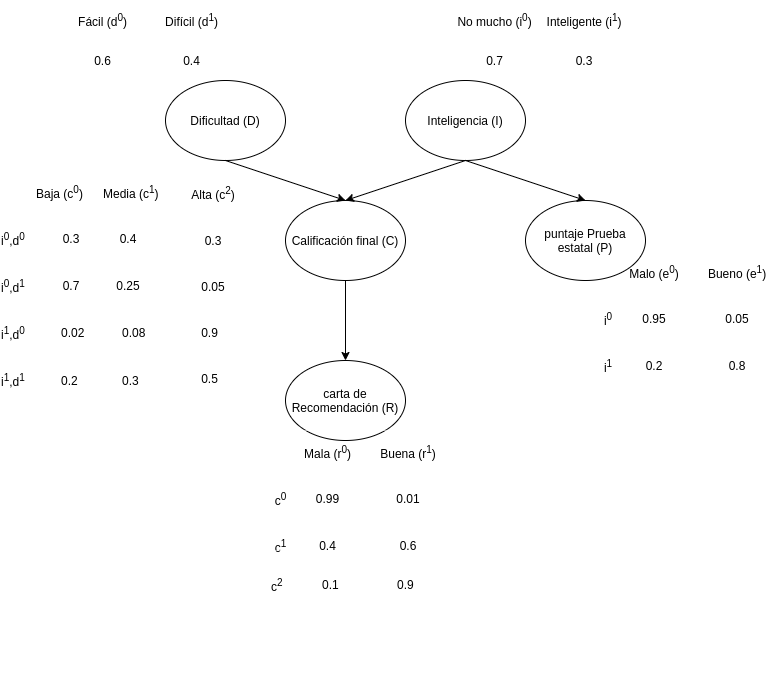

In [67]:
Image("figures/Student1.png")

Let's assume that we want to sample the distribution $P_{\Phi}(D, I, C | p^1, r^0)$.

Starting sample: $d^0, i^0, c^1$.

| Sample          | Distribution to sample from   |
| --------------- | ----------------------------- |
| $d^0, i^0, c^1$ | $P(D|i^0, c^1, p^1, r^0)$     |
| $d^1, i^0, c^1$ | $P(I|d^1, c^1, p^1, r^0)$     |
| $d^1, i^1, c^1$ | $P(C|d^1, i^1, p^1, r^0)$     |
| $d^1, i^1, c^1$ | This is $x^{(1)}$             |

In [68]:
# Import pgmpy.sampling.GibbsSampling
from pgmpy.sampling import GibbsSampling

In [69]:
# Instantiate a sampling object
sampling = GibbsSampling(model)

In [70]:
# Generate N samples
samples = sampling.sample(size=300000)

100%|██████████| 299999/299999 [01:55<00:00, 2594.76it/s]


In [71]:
samples.head()

,D,C,I,R,E
0,1,0,0,0,0
1,0,1,0,1,0
2,0,1,0,1,0
3,0,1,0,0,0
4,0,2,0,0,0


In [83]:
import pandas as pd

In [93]:
# Use rolling to get statistics on windows of predefined size
df = pd.get_dummies(samples['C']).rolling(window=2 * M).sum() / (2 * M)

In [94]:
df

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
299995,0.370225,0.287747,0.342028
299996,0.370244,0.287747,0.342009
299997,0.370263,0.287747,0.341990
299998,0.370282,0.287747,0.341971


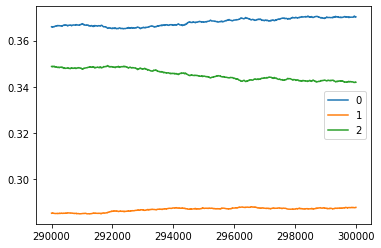

In [96]:
# Plot
df.iloc[-10000:].plot()

In [92]:
# Compare
print(P_C)

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.3620 |
+------+----------+
| C(1) |   0.2884 |
+------+----------+
| C(2) |   0.3496 |
+------+----------+


# Announcements

## The exam is scheduled for the next session. However, I won't be able to attend class on November, 3rd.

## I propose that we have class the next session (first class module 3), and that you do the exam on November, 3rd.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>